## Proyecto 3. Entrega 3
### Regresion Lineal
Diego Duarte 22075 - José Marchena 22398 - Andrés Kou 22305 - Esteban Zambrano 22119

#### Importaciones


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

from pipeline import crear_pipeline_knn          

#### Carga y preparación de datos

In [3]:
# Cargar dataset
df = pd.read_csv("../DataFinal.csv")

# Columnas categóricas
categoricas = ['Grupo de Edad', 'Año']
df[categoricas] = df[categoricas].astype(str)        

# Eliminar filas sin valor objetivo
df = df[df['Total Nacimientos'].notna()]

#### Variables (X / y) y One-Hot Encoding

In [4]:
y = df['Total Nacimientos']
X = df.drop(columns=['Total Nacimientos'])

X = pd.get_dummies(X, columns=categoricas, drop_first=True) 

#### División train / test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#### Creación y entrenamiento del pipeline (KNN básico)

In [6]:
modelo_knn = KNeighborsRegressor(n_neighbors=5, weights='distance', p=2)
pipeline = crear_pipeline_knn(modelo_knn)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('model', KNeighborsRegressor(weights='distance'))])

#### Evaluación del modelo (básico)

KNN básico:
MAE: 2701.696572228741
MSE: 16877291.49722138
RMSE: 4108.19808398054
R²: 0.9859665361391375


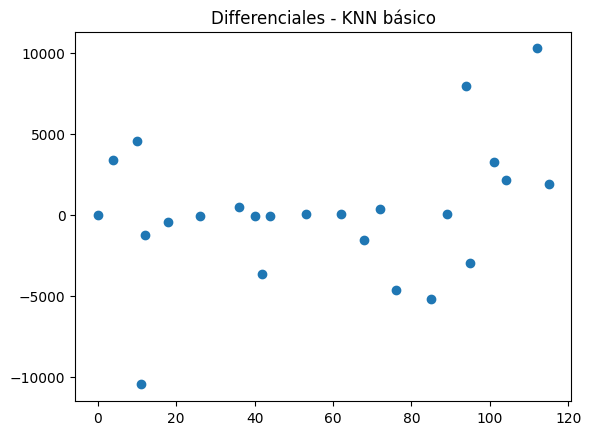

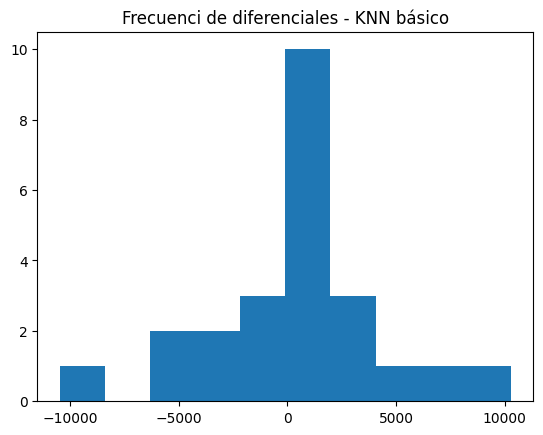

In [7]:
from error_metrics import calculate_errors, diff_analysis

y_pred = pipeline.predict(X_test)

calculate_errors(y_pred, y_test, "KNN básico")
diff_analysis(y_pred, y_test, "KNN básico")

KNN básico:
MAE: 2701.696572228741
MSE: 16877291.49722138
RMSE: 4108.19808398054
R²: 0.9859665361391375


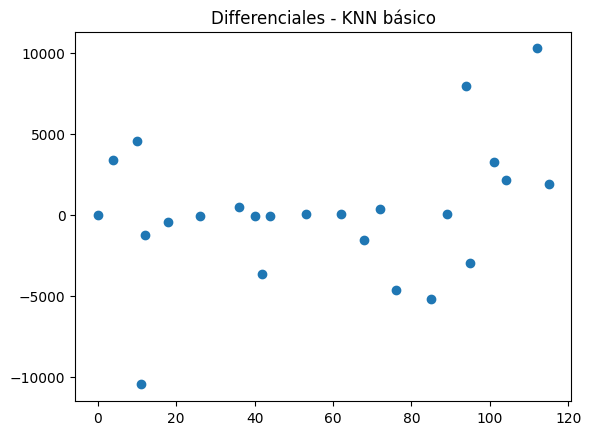

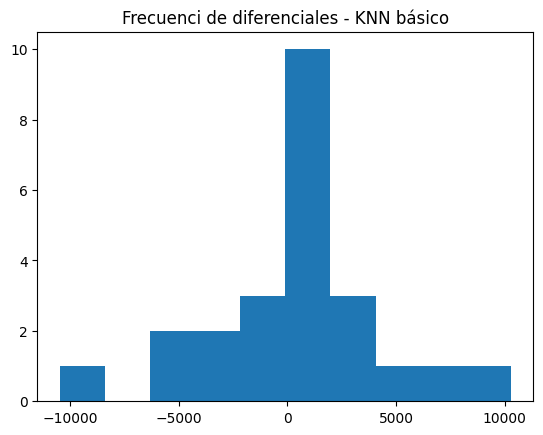

In [8]:
calculate_errors(y_pred, y_test, "KNN básico")
diff_analysis(y_pred, y_test, "KNN básico")

#### Gráfica: valor real vs. predicción (KNN básico)

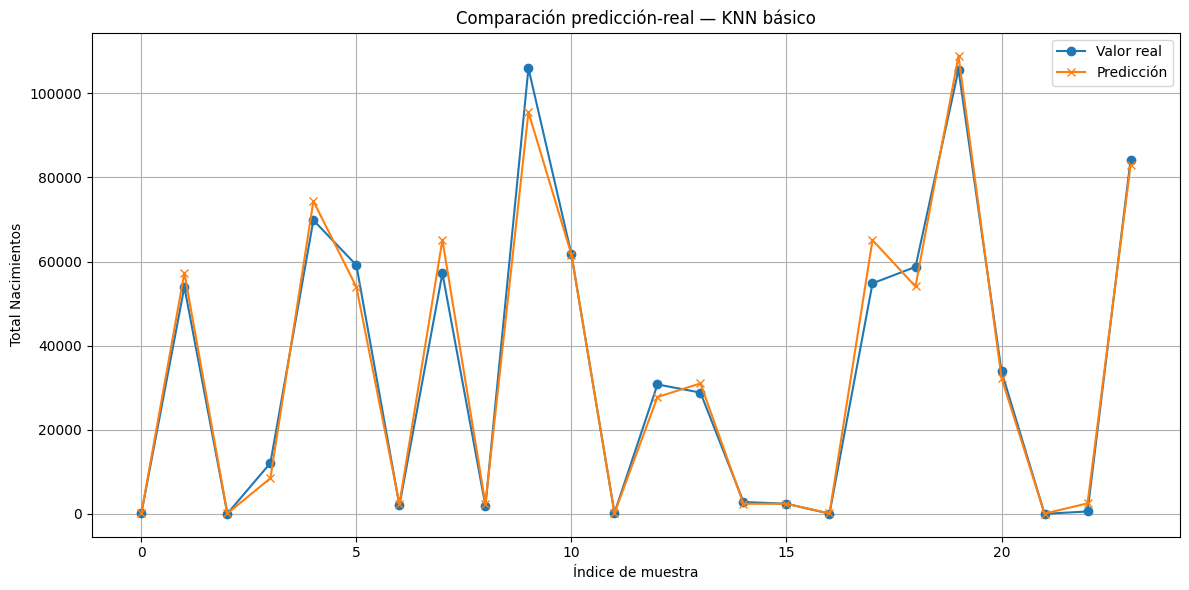

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True), label='Valor real', marker='o')
plt.plot(pd.Series(y_pred, name="Predicción"), label='Predicción', marker='x')
plt.title('Comparación predicción-real — KNN básico')
plt.xlabel('Índice de muestra')
plt.ylabel('Total Nacimientos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Búsqueda de hiperparámetros (Grid Search)

In [10]:
param_grid = {
    'model__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2]          
}

gs = GridSearchCV(
    crear_pipeline_knn(KNeighborsRegressor()),      
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

gs.fit(X_train, y_train)

print("Mejores hiperparámetros:", gs.best_params_)
mejor_knn = gs.best_estimator_

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Mejores hiperparámetros: {'model__n_neighbors': 3, 'model__p': 1, 'model__weights': 'uniform'}


#### Evaluación del mejor KNN


KNN optimizado:
MAE: 1935.9722222222226
MSE: 13390670.65740741
RMSE: 3659.3265305801024
R²: 0.9888656605371557


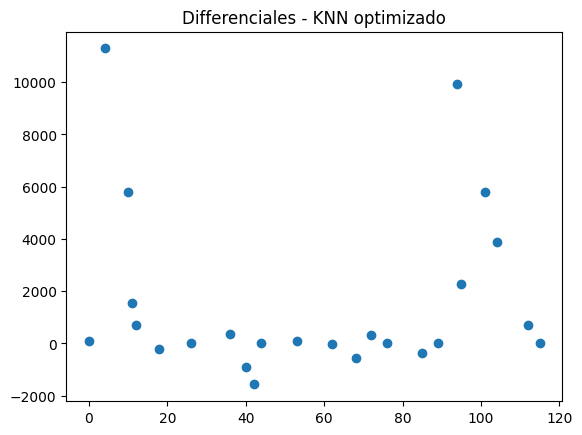

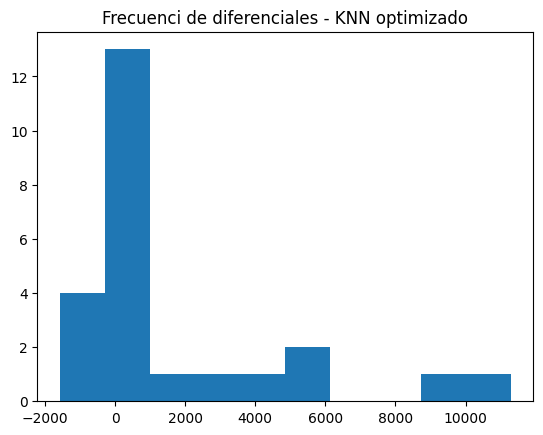

In [11]:
# Predicciones con los hiperparámetros óptimos
y_pred_opt = mejor_knn.predict(X_test)

# Métricas y análisis de diferencia
calculate_errors(y_pred_opt, y_test, "KNN optimizado")
diff_analysis(y_pred_opt, y_test, "KNN optimizado")


#### Gráfica: valor real vs. predicción (KNN optimizado)

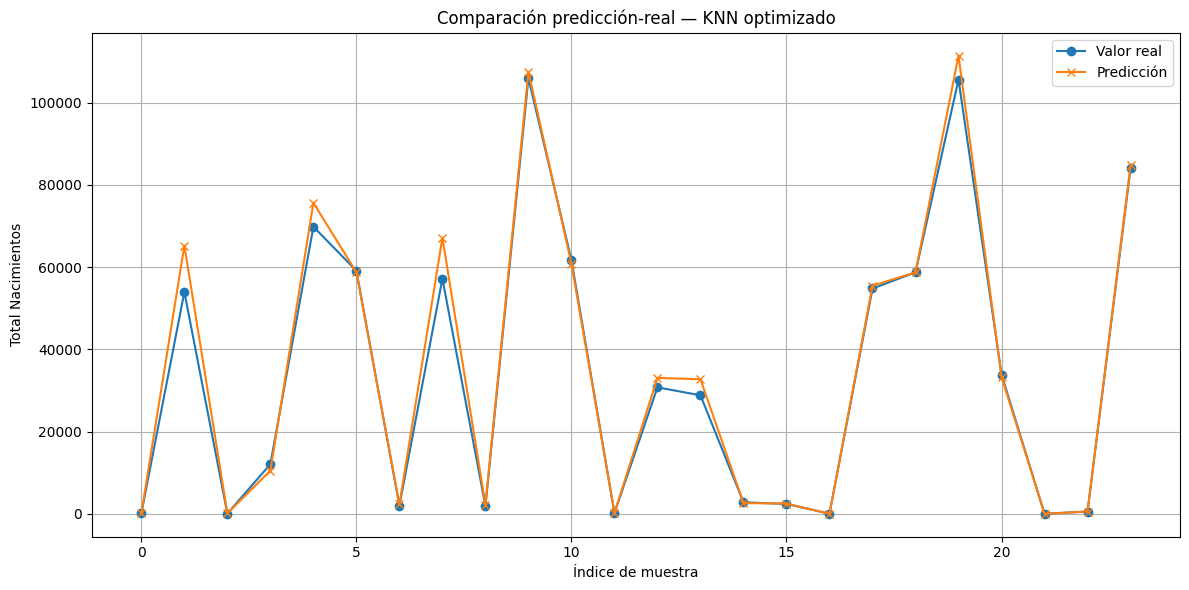

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True), label='Valor real', marker='o')
plt.plot(pd.Series(y_pred_opt, name="Predicción"), label='Predicción', marker='x')
plt.title('Comparación predicción-real — KNN optimizado')
plt.xlabel('Índice de muestra')
plt.ylabel('Total Nacimientos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Curva de aprendizaje — KNN optimizado

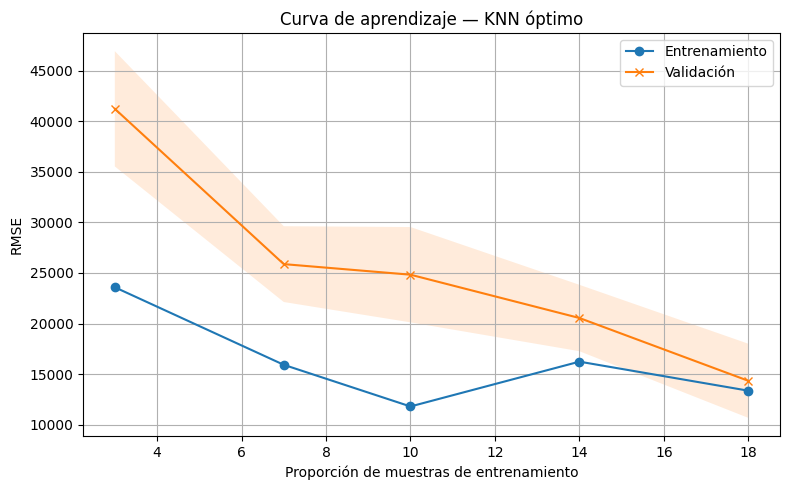

In [13]:
from sklearn.model_selection import learning_curve, TimeSeriesSplit
import numpy as np

# 1) definimos los tamaños de entrenamiento (20 %, 35 %, …, 100 %)
train_sizes = np.linspace(0.2, 1.0, 5)

# 2) usamos un split temporal para no mezclar años
tscv = TimeSeriesSplit(n_splits=5)

# 3) learning_curve devuelve error de entrenamiento y validación
train_sizes, train_scores, val_scores = learning_curve(
    mejor_knn,
    X_train,
    y_train,
    train_sizes=train_sizes,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    shuffle=False  # muy importante: mantiene el orden temporal
)

# Pasamos a RMSE positivo
train_rmse = -train_scores
val_rmse   = -val_scores

# 4) promediamos sobre los folds y graficamos
train_mean = train_rmse.mean(axis=1)
train_std  = train_rmse.std(axis=1)
val_mean   = val_rmse.mean(axis=1)
val_std    = val_rmse.std(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, label="Entrenamiento", marker='o')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.15)
plt.plot(train_sizes, val_mean,   label="Validación",   marker='x')
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.15)
plt.title("Curva de aprendizaje — KNN óptimo")
plt.xlabel("Proporción de muestras de entrenamiento")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Prueba rápida sin limpieza con solo columnas numéricas

KNN sin limpieza:
MAE: 3064.152777777778
MSE: 33536626.6712963
RMSE: 5791.081649510417
R²: 0.9721143029090684


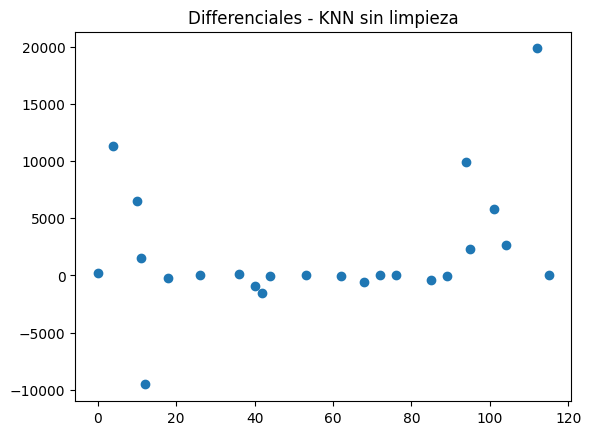

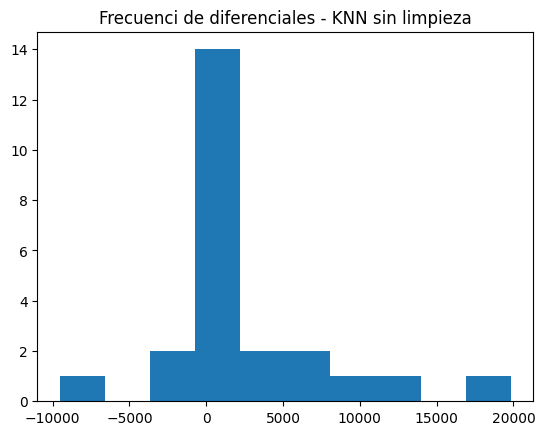

In [14]:
df_sin = pd.read_csv("../DataFinal.csv")
df_sin = df_sin[df_sin['Total Nacimientos'].notna()]

y_sin = df_sin['Total Nacimientos']
X_sin = df_sin.drop(columns=['Total Nacimientos']).select_dtypes('number')

X_train_sin, X_test_sin, y_train_sin, y_test_sin = train_test_split(
    X_sin, y_sin, test_size=0.2, random_state=42
)

modelo_sin = KNeighborsRegressor(
    n_neighbors=gs.best_params_['model__n_neighbors'],
    weights=gs.best_params_['model__weights'],
    p=gs.best_params_['model__p']
)
pipeline_sin = crear_pipeline_knn(modelo_sin)
pipeline_sin.fit(X_train_sin, y_train_sin)

y_pred_sin = pipeline_sin.predict(X_test_sin)
calculate_errors(y_pred_sin, y_test_sin, "KNN sin limpieza")
diff_analysis(y_pred_sin, y_test_sin, "KNN sin limpieza")

KNN sin limpieza:
MAE: 3064.152777777778
MSE: 33536626.6712963
RMSE: 5791.081649510417
R²: 0.9721143029090684


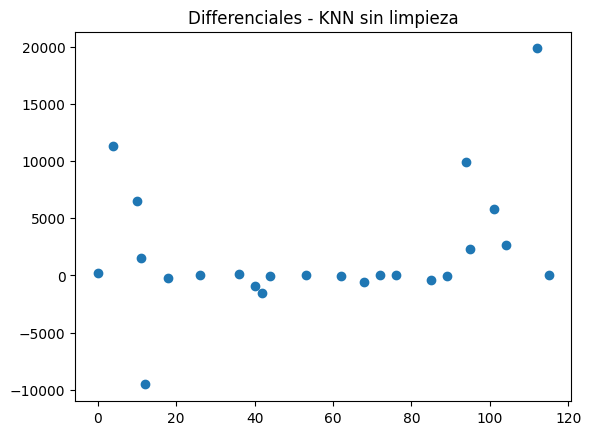

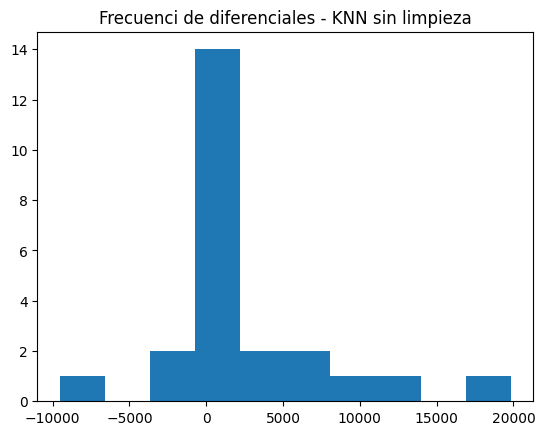

In [15]:
calculate_errors(y_pred_sin, y_test_sin, "KNN sin limpieza")
diff_analysis(y_pred_sin, y_test_sin, "KNN sin limpieza")

#### Gráfica: valor real vs. predicción (KNN sin limpieza)

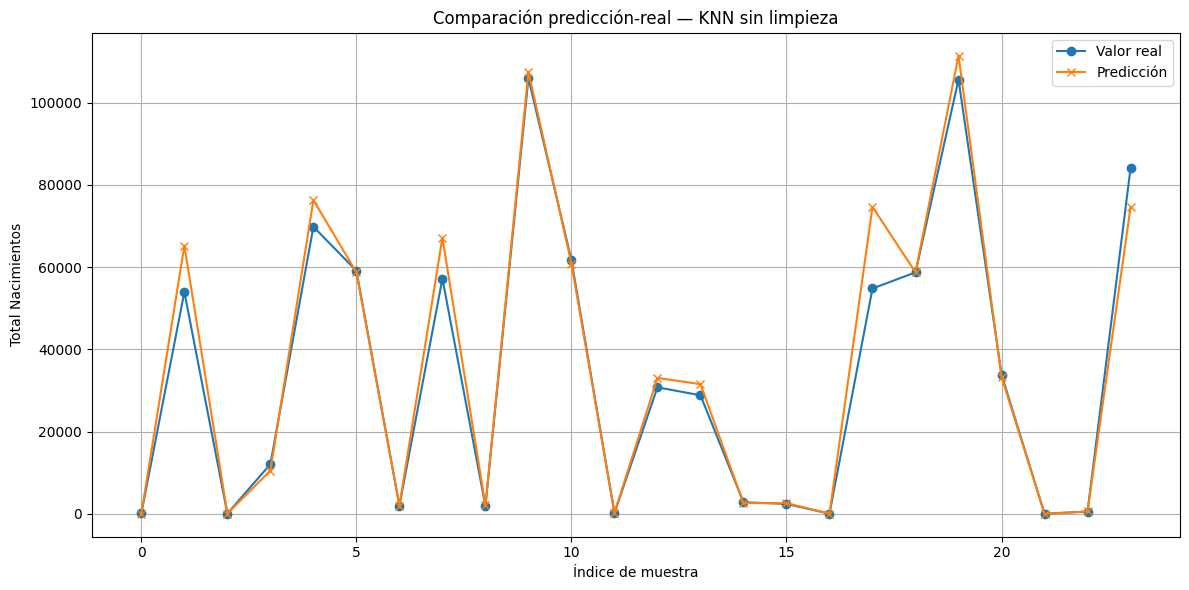

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_sin.reset_index(drop=True), label='Valor real', marker='o')
plt.plot(pd.Series(y_pred_sin, name="Predicción"), label='Predicción', marker='x')
plt.title('Comparación predicción-real — KNN sin limpieza')
plt.xlabel('Índice de muestra')
plt.ylabel('Total Nacimientos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()